# 🌮 Orderly - Smart Food Recommender

# Step 1: Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
from datetime import datetime
from numpy import radians, cos, sin, sqrt, arctan2

# Step 2: Load Dataset

In [2]:
data_path = "../backend/data/dataset.csv"
orders = pd.read_csv(data_path)
print(orders.head())

   Restaurant ID Restaurant name   Subzone       City    Order ID  \
0       20320607           Swaad  Sector 4  Delhi NCR  6168884918   
1       20320607           Swaad  Sector 4  Delhi NCR  6170707559   
2       20320607           Swaad  Sector 4  Delhi NCR  6169375019   
3       20320607           Swaad  Sector 4  Delhi NCR  6151677434   
4       20320607           Swaad  Sector 4  Delhi NCR  6167540897   

               Order Placed At Order Status         Delivery Distance  \
0  11:38 PM, September 10 2024    Delivered  Zomato Delivery      3km   
1  11:34 PM, September 10 2024    Delivered  Zomato Delivery      2km   
2  03:52 PM, September 10 2024    Delivered  Zomato Delivery     <1km   
3  03:45 PM, September 10 2024    Delivered  Zomato Delivery      2km   
4  03:04 PM, September 10 2024    Delivered  Zomato Delivery      2km   

                                      Items in order  ... Rating Review  \
0  1 x Grilled Chicken Jamaican Tender, 1 x Grill...  ...    NaN    NaN

# Step 3: Distance Cleaning

In [3]:
def clean_distance(x):
    if pd.isna(x):
        return np.nan
    x = str(x).replace("km","").replace("<","0.5").strip()
    try:
        return float(x)
    except:
        return np.nan

orders['Distance'] = orders['Distance'].apply(clean_distance)
orders['Distance'] = orders['Distance'].fillna(orders['Distance'].median())

# Step 4: Inspect Columns & Missing Values

In [4]:
orders.columns
orders.info()
orders.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21321 entries, 0 to 21320
Data columns (total 29 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Restaurant ID                                       21321 non-null  int64  
 1   Restaurant name                                     21321 non-null  object 
 2   Subzone                                             21321 non-null  object 
 3   City                                                21321 non-null  object 
 4   Order ID                                            21321 non-null  int64  
 5   Order Placed At                                     21321 non-null  object 
 6   Order Status                                        21321 non-null  object 
 7   Delivery                                            21321 non-null  object 
 8   Distance                                            21321 non-null  float64


Restaurant ID                                             0
Restaurant name                                           0
Subzone                                                   0
City                                                      0
Order ID                                                  0
Order Placed At                                           0
Order Status                                              0
Delivery                                                  0
Distance                                                  0
Items in order                                            0
Instructions                                          20601
Discount construct                                     5498
Bill subtotal                                             0
Packaging charges                                         0
Restaurant discount (Promo)                               0
Restaurant discount (Flat offs, Freebies & others)        0
Gold discount                           

# Step 5: Preprocessing

## a) Encode Categorical Columns

In [5]:
categorical_cols = ['Restaurant ID', 'Restaurant name', 'Subzone', 'City', 'Order Status', 'Customer complaint tag']
le_dict = {}
for col in categorical_cols:
    orders[col] = orders[col].astype(str).fillna('unknown')
    le = LabelEncoder()
    orders[col + '_enc'] = le.fit_transform(orders[col])
    le_dict[col] = le

## b) Extract Time Features

In [6]:
orders['Order Placed At'] = pd.to_datetime(
    orders['Order Placed At'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

orders['Order_Hour'] = orders['Order Placed At'].dt.hour
orders['Order_Day'] = orders['Order Placed At'].dt.dayofweek

print(orders[['Order Placed At', 'Order_Hour', 'Order_Day']].head())


  Order Placed At  Order_Hour  Order_Day
0             NaT         NaN        NaN
1             NaT         NaN        NaN
2             NaT         NaN        NaN
3             NaT         NaN        NaN
4             NaT         NaN        NaN


## c) Fill Missing Numerical Values

In [7]:
num_cols = ['Bill subtotal','Packaging charges','Restaurant discount (Promo)',
            'Restaurant discount (Flat offs, Freebies & others)','Gold discount','Brand pack discount',
            'Total','KPT duration (minutes)','Rider wait time (minutes)']
for col in num_cols:
    orders[col] = pd.to_numeric(orders[col], errors='coerce')
    orders[col] = orders[col].fillna(orders[col].median())

# d) Feature Engineering

In [8]:
orders['Order Placed At'] = pd.to_datetime(orders['Order Placed At'], errors='coerce')
orders['Order_Hour'] = orders['Order Placed At'].dt.hour
orders['Order_Day'] = orders['Order Placed At'].dt.dayofweek

# e) Text features

In [9]:
orders['num_items'] = orders['Items in order'].apply(lambda x: len(str(x).split(',')))
orders['instructions_len'] = orders['Instructions'].apply(lambda x: len(str(x)))

## f) Define Target

In [10]:
orders['target'] = (orders['Rating'] >= 4).astype(int)

# Step 6: Feature Selection

In [11]:
feature_cols = ['Restaurant ID_enc','Restaurant name_enc','Subzone_enc','City_enc',
                'Distance','Bill subtotal','Packaging charges','Restaurant discount (Promo)',
                'Restaurant discount (Flat offs, Freebies & others)','Gold discount','Brand pack discount',
                'Total','KPT duration (minutes)','Rider wait time (minutes)',
                'Order_Hour','Order_Day','num_items','instructions_len']

X = orders[feature_cols]
y = orders['target']

# Step 7: Train/Test Split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train RandomForest Model

In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Validation

In [14]:
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.8968347010550997
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3822
           1       0.57      0.03      0.06       443

    accuracy                           0.90      4265
   macro avg       0.73      0.51      0.50      4265
weighted avg       0.86      0.90      0.85      4265



# Step 9: Save Model

In [15]:
import os
import joblib

save_path = "../backend/models"
file_name = "food_delivery_model.pkl"

os.makedirs(save_path, exist_ok=True)

full_path = os.path.join(save_path, file_name)

joblib.dump(model, full_path)
print(f"Model saved as '{full_path}'!")


Model saved as '../backend/models/food_delivery_model.pkl'!


# Step 10: Visualizations

## a) Feature Importance

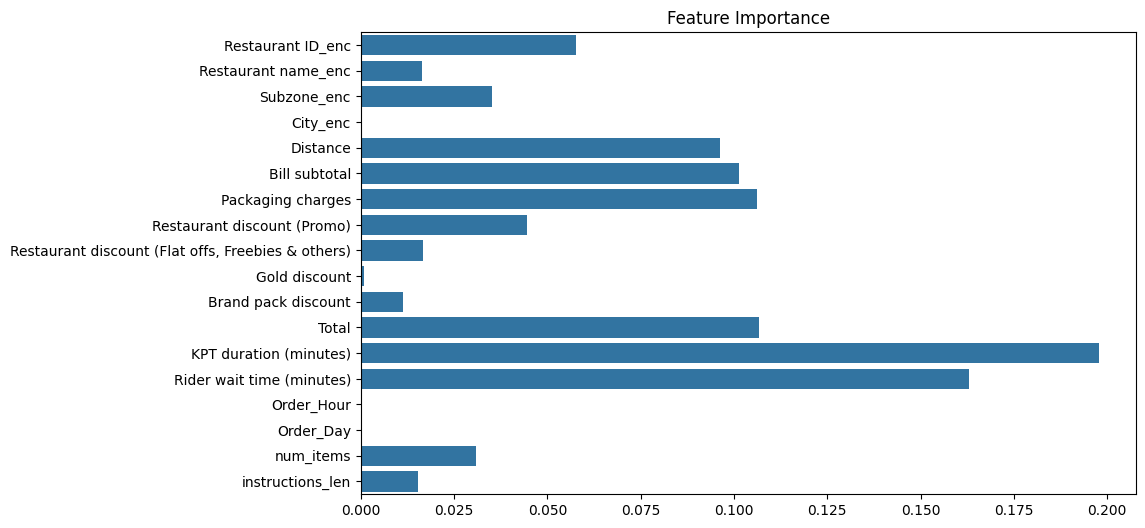

In [16]:
importances = model.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance")
plt.show()

## b) Distance Distribution

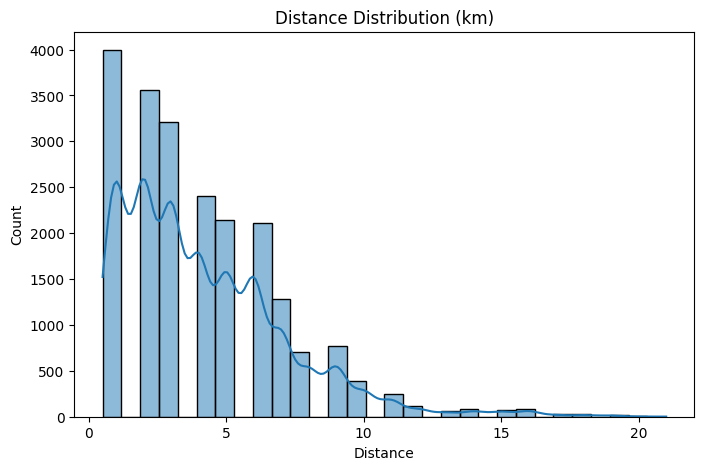

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(orders['Distance'], bins=30, kde=True)
plt.title("Distance Distribution (km)")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show()

## c) Rating Distribution

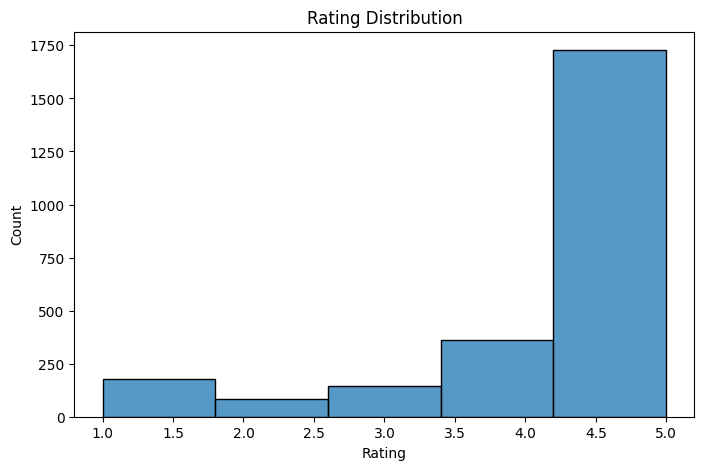

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(orders['Rating'], bins=5, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## d) KPT Duration vs Target

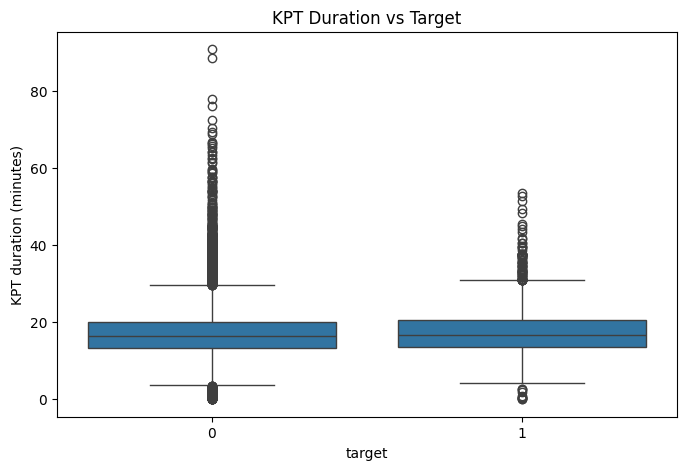

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x='target', y='KPT duration (minutes)', data=orders)
plt.title("KPT Duration vs Target")
plt.show()